In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import psycopg2 as pg_driver

from matplotlib import pyplot as plt
%matplotlib inline

from Bio import Entrez

Entrez.email = 'nikolay.kapralov@gmail.com'
PUBMED_ARTICLE_BASE_URL = 'https://www.ncbi.nlm.nih.gov/pubmed/?term='

In [2]:
def search(*terms):
    query=' '.join(terms)
    handle = Entrez.esearch(db='pubmed',  
                            retmax='100000',
                            retmode='xml', 
                            term=query)
    results = Entrez.read(handle)
    return results

In [3]:
terms = ['DNA', 'methylation', 'clock']

results = search(*terms)['IdList']
print(f'{len(results)} articles about {terms}')

290 articles about ['DNA', 'methylation', 'clock']


A file with citation stats is required to run next cell successfully.
The file can be obtained with the following commands if user has access to `pubmed` database (use crawler).

1. Run `psql`.
2. Run following commands in the `psql` prompt:
    * `\f ','`
    * `\a`
    * `\t`
    * `\o '/path/to/the/file'`
    * `SELECT C.pmid_cited AS pmid, P.year, COUNT(1) AS count`
    * `FROM Citations C`
    * `JOIN Publications P`
    * `ON C.pmid_citing = P.pmid`
    * `GROUP BY C.pmid_cited, P.year;`
    * `\o`
3. Store '/path/to/the/file' in the `CITATION_STATS_FILE` variable in the following cell.

In [4]:
%%time

data = []
CITATION_STATS_FILE = '../citations_per_year.csv'
with open(CITATION_STATS_FILE, 'r') as f:
    for line in f:
        pmid, year, count = line[:-1].split(',')
        if pmid in results:
            data.append([pmid, year, count])

Wall time: 12min 14s


In [5]:
data[0]

['1722018', '1994', '2']

In [6]:
df = pd.DataFrame(data, columns = ['pmid', 'year', 'count'])
for col in df:
    df[col] = df[col].astype(str).replace('', 0) # some papers without recognized year -- more tests for parser
    df[col] = df[col].astype(int)
print(len(df))
print(df[df['year'] == 0])
df = df[df['year'] > 0]
print(len(df))

674
         pmid  year  count
31    2777259     0      1
57   11820819     0      1
75   15790588     0      3
92   15941485     0      1
111  16314580     0      2
140  16717091     0      1
235  19861541     0      1
309  22080730     0      1
317  22348461     0      1
374  23217262     0      1
398  24138928     0      1
433  24884411     0      1
662


In [7]:
year_min = df['year'].min()
year_max = df['year'].max()

,citing,cited_1,cited_2,year,min_cited,max_cited
0,16457718,15975143,16314580,2006.0,15975143,16314580
1,16457718,16314580,15975143,2006.0,15975143,16314580
2,16760426,1722018,15975143,2006.0,1722018,15975143
3,16760426,15975143,1722018,2006.0,1722018,15975143
4,17335343,15975143,16314580,2007.0,15975143,16314580


Text(0,0.5,'Number of citations')

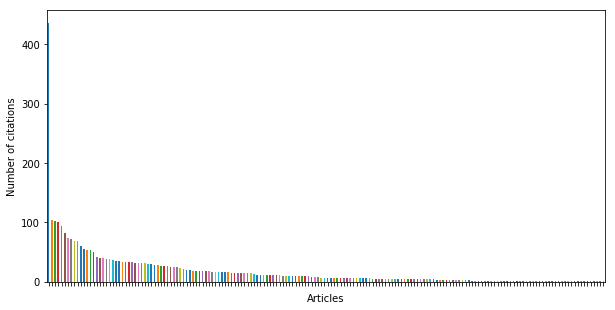

In [8]:
total_citations = df.groupby('pmid')['count'].sum().reset_index().sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 5))
ax = total_citations['count'].plot.bar()
ax.set_xticklabels([])
ax.set_xlabel('Articles')
ax.set_ylabel('Number of citations')

In [9]:
threshold_of_interest = 0.05

articles = total_citations.iloc[:round(len(total_citations) * threshold_of_interest), 0].values
counts = total_citations.iloc[:round(len(total_citations) * threshold_of_interest), 1].values
urls = [PUBMED_ARTICLE_BASE_URL + str(article) for article in articles]
for url, count in zip(urls, counts):
    print(url, count)

https://www.ncbi.nlm.nih.gov/pubmed/?term=24138928 436
https://www.ncbi.nlm.nih.gov/pubmed/?term=25313081 104
https://www.ncbi.nlm.nih.gov/pubmed/?term=15790588 102
https://www.ncbi.nlm.nih.gov/pubmed/?term=2777259 101
https://www.ncbi.nlm.nih.gov/pubmed/?term=15860628 94
https://www.ncbi.nlm.nih.gov/pubmed/?term=22438023 82
https://www.ncbi.nlm.nih.gov/pubmed/?term=25617346 74
https://www.ncbi.nlm.nih.gov/pubmed/?term=23217262 72
https://www.ncbi.nlm.nih.gov/pubmed/?term=25678027 69


In [10]:
def plot_citation_timeline(pmid):
    df_sel = df[df['pmid'] == pmid].reset_index()
    df_sel.plot('year', 'count', marker='o', figsize=(10, 5))

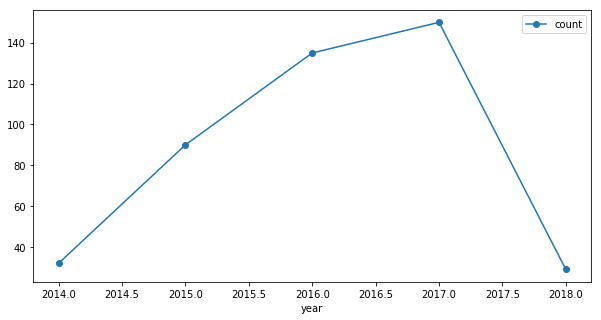

In [11]:
# DNA methylation age of human tissues and cell types. Horvath S.
plot_citation_timeline(24138928)

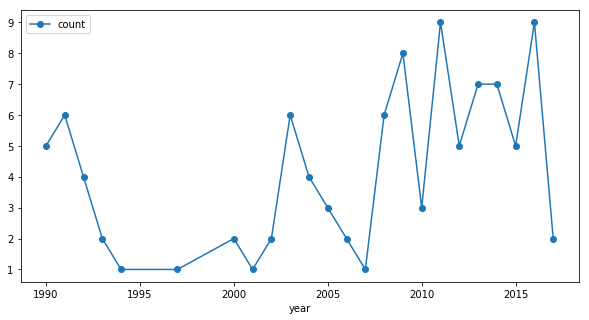

In [12]:
# Cytosine methylation and the fate of CpG dinucleotides in vertebrate genomes. Cooper DN1, Krawczak M.
plot_citation_timeline(2777259)

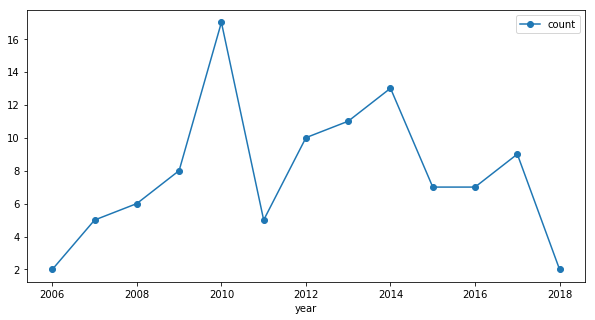

In [13]:
# Deregulated expression of the PER1, PER2 and PER3 genes in breast cancers. Chen ST1, Choo KB, Hou MF, Yeh KT, Kuo SJ, Chang JG.
plot_citation_timeline(15790588)

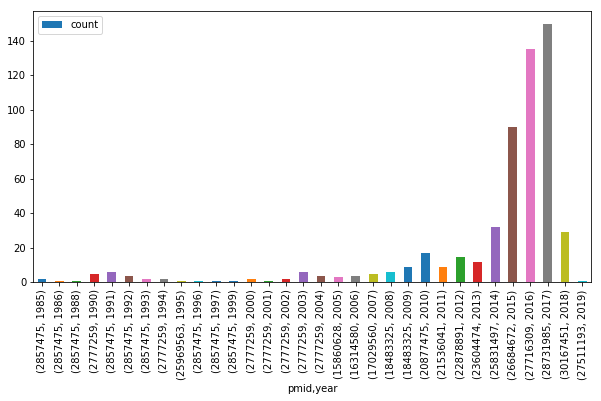

In [14]:
max_gain = df.groupby('year')['pmid', 'count'].max().reset_index().sort_values('year')
max_gain.plot.bar(['pmid', 'year'], 'count', figsize=(10, 5))

In [15]:
max_gain

,year,pmid,count
0,1985,2857475,2
1,1986,2857475,1
2,1988,2857475,1
3,1990,2777259,5
4,1991,2857475,6
5,1992,2857475,4
6,1993,2857475,2
7,1994,2777259,2
8,1995,25969563,1
9,1996,2857475,1


In [16]:
max_gain_last_year = max_gain.groupby('pmid')['year'].max().reset_index().sort_values('year')

articles_gain = max_gain_last_year.iloc[:, 0].values
years = max_gain_last_year.iloc[:, 1].values
urls = [PUBMED_ARTICLE_BASE_URL + str(article) for article in articles_gain]
for url, year in zip(urls, years):
    print(url, year)

https://www.ncbi.nlm.nih.gov/pubmed/?term=25969563 1995
https://www.ncbi.nlm.nih.gov/pubmed/?term=2857475 1999
https://www.ncbi.nlm.nih.gov/pubmed/?term=2777259 2004
https://www.ncbi.nlm.nih.gov/pubmed/?term=15860628 2005
https://www.ncbi.nlm.nih.gov/pubmed/?term=16314580 2006
https://www.ncbi.nlm.nih.gov/pubmed/?term=17029560 2007
https://www.ncbi.nlm.nih.gov/pubmed/?term=18483325 2009
https://www.ncbi.nlm.nih.gov/pubmed/?term=20877475 2010
https://www.ncbi.nlm.nih.gov/pubmed/?term=21536041 2011
https://www.ncbi.nlm.nih.gov/pubmed/?term=22878891 2012
https://www.ncbi.nlm.nih.gov/pubmed/?term=23604474 2013
https://www.ncbi.nlm.nih.gov/pubmed/?term=25831497 2014
https://www.ncbi.nlm.nih.gov/pubmed/?term=26684672 2015
https://www.ncbi.nlm.nih.gov/pubmed/?term=27716309 2016
https://www.ncbi.nlm.nih.gov/pubmed/?term=28731985 2017
https://www.ncbi.nlm.nih.gov/pubmed/?term=30167451 2018
https://www.ncbi.nlm.nih.gov/pubmed/?term=27511193 2019


In [17]:
conn = pg_driver.connect(dbname='pubmed', user='biolabs', password='pubtrends', host='localhost')
cursor = conn.cursor()

In [18]:
%%time

pmids = [int(pmid) for pmid in results]

query = '''
SELECT pmid_citing, pmid_cited
FROM Citations
WHERE pmid_citing = ANY(%s) AND pmid_cited = ANY(%s);
'''

with conn:
    cursor.execute(query, (pmids, pmids,))

Wall time: 9.98 s


In [19]:
data = []

for row in cursor:
    data.append(row)
    
print(len(data))

628


In [20]:
G = nx.DiGraph(data)

In [21]:
len(G.nodes)

151

In [22]:
list(nx.simple_cycles(G))

[[26684672, 26678252], [24884411]]

In [23]:
# Another test for parser -- self-loop
for v, u in G.edges():
    if v == 24884411:
        print(v, u)

24884411 24884411


In [24]:
nx.write_graphml(G, 'dna-methylation-clock.graphml')

In [25]:
%%time

pmids = [int(pmid) for pmid in results]

query = '''
SELECT C1.pmid_citing, C1.pmid_cited, C2.pmid_cited, P.year
FROM Citations C1
JOIN Citations C2
ON C1.pmid_citing = C2.pmid_citing 
JOIN Publications P
ON C1.pmid_citing = P.pmid
WHERE C1.pmid_cited = ANY(%s) AND C2.pmid_cited = ANY(%s);
'''

with conn:
    cursor.execute(query, (pmids, pmids,))

Wall time: 1h 30min 4s


In [26]:
cocit_data = []

for row in cursor:
    row = list(row)
    if row[1] != row[2]:
        cocit_data.append(row)
    
print(len(cocit_data))

9752


In [27]:
cocit_data[0]

[16457718, 15975143, 16314580, 2006]

In [28]:
df = pd.DataFrame(cocit_data, columns=['citing', 'cited_1', 'cited_2', 'year'])

In [29]:
df.head()

,citing,cited_1,cited_2,year
0,16457718,15975143,16314580,2006.0
1,16457718,16314580,15975143,2006.0
2,16760426,1722018,15975143,2006.0
3,16760426,15975143,1722018,2006.0
4,17335343,15975143,16314580,2007.0


In [30]:
# Sort PMIDs of co-cited articles to avoid (a,b) & (b,a) duplication (can be also solved in SQL)
df['min_cited'] = df[['cited_1', 'cited_2']].min(axis=1)
df['max_cited'] = df[['cited_1', 'cited_2']].max(axis=1)

In [31]:
df.head()

,citing,cited_1,cited_2,year,min_cited,max_cited
0,16457718,15975143,16314580,2006.0,15975143,16314580
1,16457718,16314580,15975143,2006.0,15975143,16314580
2,16760426,1722018,15975143,2006.0,1722018,15975143
3,16760426,15975143,1722018,2006.0,1722018,15975143
4,17335343,15975143,16314580,2007.0,15975143,16314580


In [32]:
cocit = df.groupby(['min_cited', 'max_cited']).count()

In [33]:
cocit_grouped = []
for idx, val in cocit.iteritems():
    for i, v in val.iteritems():
        cocit_grouped.append((i[0], i[1], v))

In [34]:
CG = nx.Graph()
for t in cocit_grouped:
    CG.add_edge(t[0], t[1], weight=t[2])

In [35]:
len(CG.nodes)

138

In [37]:
nx.is_connected(CG)

True

In [38]:
nx.write_graphml(CG, 'dna-methylation-clock-cocitations.graphml')

In [39]:
cocit_weights = [el[2] for el in list(CG.edges.data('weight'))]

Text(0,0.5,'Number of occurences')

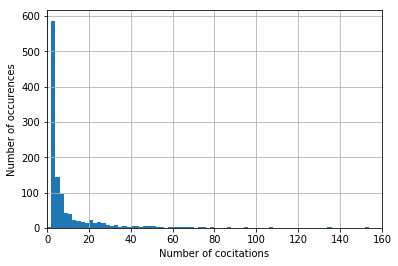

In [40]:
h = plt.hist(cocit_weights, bins=np.linspace(0, 160, 81))
plt.xlim([0, 160])
plt.grid(True)
plt.xlabel('Number of cocitations')
plt.ylabel('Number of occurences')

In [41]:
threshold_cocitation = 10
edges_of_interest = []

for a, b, data in sorted(CG.edges(data=True), key=lambda x: x[2]['weight'], reverse=True):
    if data['weight'] >= threshold_cocitation:
        edges_of_interest.append((a, b))

In [42]:
for a, b, data in sorted(CG.edges(data=True), key=lambda x: x[2]['weight'], reverse=True):
    w = data['weight']
#     print(f'{a} {b} {w}')

In [43]:
CG_sel = CG.edge_subgraph(edges_of_interest)

In [44]:
nx.is_connected(CG_sel)

False

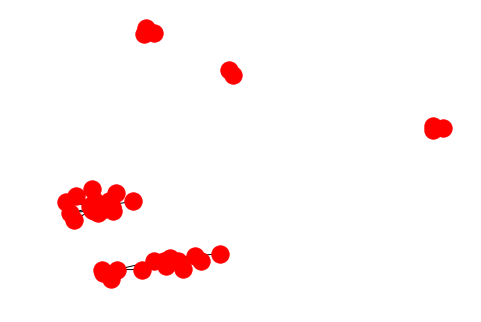

In [45]:
nx.draw(CG_sel)

In [95]:
def get_title(pmid):
    handle = Entrez.efetch(db='pubmed', id=pmid, retmode='xml')
    results = Entrez.read(handle)
    return results['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleTitle']

In [281]:
comps = nx.connected_components(CG_sel)
for i, c in enumerate(comps):
    print(f'Component #{i + 1}')
    for v in c:
        print(PUBMED_ARTICLE_BASE_URL + str(v), get_title(v))
    print()

Component #1
https://www.ncbi.nlm.nih.gov/pubmed/?term=26684672 Epigenetic age of the pre-frontal cortex is associated with neuritic plaques, amyloid load, and Alzheimer's disease related cognitive functioning.
https://www.ncbi.nlm.nih.gov/pubmed/?term=27457926 Menopause accelerates biological aging.
https://www.ncbi.nlm.nih.gov/pubmed/?term=27479945 Huntington's disease accelerates epigenetic aging of human brain and disrupts DNA methylation levels.
https://www.ncbi.nlm.nih.gov/pubmed/?term=27274774 Epigenetic age acceleration predicts cancer, cardiovascular, and all-cause mortality in a German case cohort.
https://www.ncbi.nlm.nih.gov/pubmed/?term=27717399 An epigenetic clock for gestational age at birth based on blood methylation data.
https://www.ncbi.nlm.nih.gov/pubmed/?term=27511193 An epigenetic clock analysis of race/ethnicity, sex, and coronary heart disease.
https://www.ncbi.nlm.nih.gov/pubmed/?term=27690265 DNA methylation-based measures of biological age: meta-analysis pred

In [111]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [119]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def get_ngrams(string):
    stop_words = set(stopwords.words('english')) 
    tokens = list(filter(lambda s: any(c.isalpha() for c in s), string.lower().replace(',', '').replace('.', '').split(' ')))
    tokens = [t for t in tokens if t not in stop_words and t not in terms]
    ngrams = list(tokens)
    for t1, t2 in zip(tokens[:-1], tokens[1:]):
        ngrams.append(t1 + ' ' + t2)
    for t1, t2, t3 in zip(tokens[:-2], tokens[1:-1], tokens[2:]):
        ngrams.append(t1 + ' ' + t2 + ' ' + t3)
    return ngrams

In [136]:
%%time

# TODO: add threshold for ratio of occurences

from collections import Counter

item_amount = 5
ngram_amount = 5
ratio = [0.6, 0.2, 0.1]

comps = nx.connected_components(CG_sel)
for i, c in enumerate(comps):
    if len(c) >= item_amount:
        ngrams = []
        for v in c:
            title = get_title(v)
            ngrams.extend(get_ngrams(title))
        most_common = []
        for w, cnt in Counter(ngrams).most_common():
            if cnt / len(c) >= ratio[len(w.split(' ')) - 1]:
                most_common.append((w, cnt / len(c)))
            if len(most_common) == ngram_amount:
                break
        print(f'Component #{i + 1}\n{len(c)} items - {c}\n{len(ngrams)} ngrams - {most_common}\n')

Component #1
31 items - {26684672, 27457926, 27479945, 27274774, 27717399, 27511193, 27690265, 25969563, 26411804, 27276709, 28198702, 24138928, 26830004, 24717494, 26655927, 25313081, 27075770, 25617346, 28399939, 28259012, 26861258, 25678027, 26000617, 26678252, 25913071, 26594032, 26925173, 26680699, 26885756, 25991677, 26673150}
618 ngrams - [('epigenetic', 0.7096774193548387), ('epigenetic age', 0.22580645161290322)]

Component #2
15 items - {24413057, 16717091, 19861541, 23319591, 25831497, 16999817, 24531307, 22847467, 16683245, 23217262, 15860628, 21811413, 22080730, 15790588, 19296127}
342 ngrams - [('circadian', 0.6666666666666666), ('gene expression', 0.2), ('circadian genes', 0.2)]

Wall time: 43.6 s
